In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import shutil
import pandas as pd
from pathlib import Path
import numpy as np
import sys
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

sys.path.append(str(Path(os.getcwd()).parent))
from data_utilities import (
    find_outliers, convert_age_from_days_to_years, draw_age_distribution, calculate_code_age_distribution)

In [2]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
DATASET_NAME = 'RGBDS-150K-test'

In [4]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = ''
resource_group = ''
workspace_name = ''

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='RGBDS-150K-test')
# dataset.download(target_path='.', overwrite=False)

In [5]:
dataset

{
  "source": [
    "('cgmmlciproddsetds', 'dataset-rgbds-Test-2023-07-12-03-42-41/**')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "548126f0-a159-4be8-a206-0e476e067b33",
    "name": "RGBDS-150K-test",
    "version": 1,
    "workspace": "Workspace.create(name='cgm-ml-prod-ci-azml', subscription_id='9b5bbfae-d5d1-4aae-a2ca-75159c0c887d', resource_group='cgm-ml-prod-ci-rg')"
  }
}

In [6]:
from azureml.core import Workspace, Dataset

# Connect to Workspace and reference Dataset
ws = Workspace.from_config()
dataset = ws.datasets[DATASET_NAME]

# Create mountcontext and mount the dataset
mount_ctx = dataset.mount()  
mount_ctx.start()  

In [7]:
# Get the mount point
dataset_mount_folder = mount_ctx.mount_point
print(dataset_mount_folder)

# List the files in the mount point
files = os.listdir(dataset_mount_folder)
print(files)

/tmp/tmptrjqxdx9
['labels.csv', 'scans']


In [8]:
df = pd.read_csv(os.path.join(dataset_mount_folder, 'labels.csv'))
df.shape

(150685, 24)

In [9]:
# total number of scan folders/children
scans_path = os.path.join(dataset_mount_folder, 'scans')
print(scans_path)
scans_f = os.listdir(scans_path)
print(f"Total number of scan folders/ children: {len(scans_f)}")

/tmp/tmptrjqxdx9/scans
Total number of scan folders/ children: 4576


In [11]:
df.head()

,scan_id,scan_step,scan_version,height,weight,muac,device_model,person_id,age,sex,depth_artifact_id,rgb_artifact_id,depth_file_path,rgb_file_path,seg_file_path,order_number,pose_data,no_of_person,device_pose,raw_header,angle,distance_to_child,depthmap_validity,pickle_file_path
0,0015cae6-178c-11ee-b1cd-6fc5ed6a033f,100,v1.2.0,67.2,7.25,13.2,HUAWEI VOG-L29,ff9f05b4-178b-11ee-b16b-2b6bcb7c4a05,424,male,0016d0a8-178c-11ee-b1ce-9f4fb659476d,001995cc-178c-11ee-b1d7-5bebc04a202e,1688160019793/5d6613d9-a980-4a74-a415-21f958a4...,1688160021803/c772d898-4f5e-4493-b55c-83d291ef...,1688554674654/c1f4bb7e-cb06-4f89-83b0-1f01d3b0...,1,"{'Pose Scores': '0.1351201832294464', 'Pose Re...",2.0,"[-0.6657566243886109, -0.7442855129318473, -0....",240x180_0.001_7_-0.32789356_0.69144475_0.59563...,-41.574315,0.362,0.891329,scans/ff9f05b4-178b-11ee-b16b-2b6bcb7c4a05/100...
1,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001a62a8-163e-11ee-9f41-6b3f2e931c4e,001beb46-163e-11ee-9f4b-9f1490c8ef63,1688016582307/573d7b71-d500-4405-b280-1669820b...,1688016584333/272385aa-966a-41d2-bbb3-0c59fc21...,1688502968618/472e1059-4bf3-4b6c-bdd9-571d7f42...,2,"{'Pose Scores': '0.9608679413795471', 'Pose Re...",1.0,"[-0.20186411074441837, -0.9794118894204097, -0...",240x180_0.001_7_-0.46710086_0.5808739_0.519281...,-12.283541,0.701,0.835544,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...
2,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001a8d78-163e-11ee-9f42-d3e4ccdc9398,001c1738-163e-11ee-9f4c-8bd600991d2e,1688016582489/820a53b3-71fc-4359-b121-33003613...,1688016584538/1492b15d-b29b-4d2c-b38f-95f1e4ae...,1688522726266/911dba6b-955e-48c0-80bc-3f08a575...,3,"{'Pose Scores': '0.9600263237953186', 'Pose Re...",1.0,"[-0.20186411074441837, -0.9794118894204097, -0...",240x180_0.001_7_-0.47196433_0.5782131_0.516334...,-11.580568,0.703,0.834557,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...
3,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001b29b8-163e-11ee-9f46-b30273146352,001ba082-163e-11ee-9f49-4f319388fb50,1688016583584/e24a0ef7-da95-4ed7-b701-2c59a6cc...,1688016583987/cca4edb6-7d82-41c4-a603-0fdc0119...,1688543185063/096d5dfc-d49d-4059-b6b9-2aa5abd7...,7,"{'Pose Scores': '0.9557691216468811', 'Pose Re...",1.0,"[-0.1738572636096072, -0.9847456179549005, 0.0...",240x180_0.001_7_-0.47883582_0.5685698_0.516323...,-10.361830,0.712,0.828863,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...
4,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001a2ca2-163e-11ee-9f40-238d53a95dd2,001bc62a-163e-11ee-9f4a-9751d203b93c,1688016582148/bca8d433-9ceb-4380-9d8b-8c7f0881...,1688016584164/a444dd43-b8bf-46b4-b7e6-6e35cd7f...,1688651875228/f0b2bc57-adfc-4ecd-9760-900bfbf6...,1,"{'Pose Scores': '0.9559937715530396', 'Pose Re...",1.0,"[-0.1738572636096072, -0.9847456179549005, 0.0...",240x180_0.001_7_-0.46728367_0.58330387_0.51934...,-12.628361,0.691,0.840193,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...


In [12]:
df['Years'] = df.apply(convert_age_from_days_to_years, axis=1)
df.head()

,scan_id,scan_step,scan_version,height,weight,muac,device_model,person_id,age,sex,depth_artifact_id,rgb_artifact_id,depth_file_path,rgb_file_path,seg_file_path,order_number,pose_data,no_of_person,device_pose,raw_header,angle,distance_to_child,depthmap_validity,pickle_file_path,Years
0,0015cae6-178c-11ee-b1cd-6fc5ed6a033f,100,v1.2.0,67.2,7.25,13.2,HUAWEI VOG-L29,ff9f05b4-178b-11ee-b16b-2b6bcb7c4a05,424,male,0016d0a8-178c-11ee-b1ce-9f4fb659476d,001995cc-178c-11ee-b1d7-5bebc04a202e,1688160019793/5d6613d9-a980-4a74-a415-21f958a4...,1688160021803/c772d898-4f5e-4493-b55c-83d291ef...,1688554674654/c1f4bb7e-cb06-4f89-83b0-1f01d3b0...,1,"{'Pose Scores': '0.1351201832294464', 'Pose Re...",2.0,"[-0.6657566243886109, -0.7442855129318473, -0....",240x180_0.001_7_-0.32789356_0.69144475_0.59563...,-41.574315,0.362,0.891329,scans/ff9f05b4-178b-11ee-b16b-2b6bcb7c4a05/100...,1
1,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001a62a8-163e-11ee-9f41-6b3f2e931c4e,001beb46-163e-11ee-9f4b-9f1490c8ef63,1688016582307/573d7b71-d500-4405-b280-1669820b...,1688016584333/272385aa-966a-41d2-bbb3-0c59fc21...,1688502968618/472e1059-4bf3-4b6c-bdd9-571d7f42...,2,"{'Pose Scores': '0.9608679413795471', 'Pose Re...",1.0,"[-0.20186411074441837, -0.9794118894204097, -0...",240x180_0.001_7_-0.46710086_0.5808739_0.519281...,-12.283541,0.701,0.835544,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...,3
2,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001a8d78-163e-11ee-9f42-d3e4ccdc9398,001c1738-163e-11ee-9f4c-8bd600991d2e,1688016582489/820a53b3-71fc-4359-b121-33003613...,1688016584538/1492b15d-b29b-4d2c-b38f-95f1e4ae...,1688522726266/911dba6b-955e-48c0-80bc-3f08a575...,3,"{'Pose Scores': '0.9600263237953186', 'Pose Re...",1.0,"[-0.20186411074441837, -0.9794118894204097, -0...",240x180_0.001_7_-0.47196433_0.5782131_0.516334...,-11.580568,0.703,0.834557,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...,3
3,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001b29b8-163e-11ee-9f46-b30273146352,001ba082-163e-11ee-9f49-4f319388fb50,1688016583584/e24a0ef7-da95-4ed7-b701-2c59a6cc...,1688016583987/cca4edb6-7d82-41c4-a603-0fdc0119...,1688543185063/096d5dfc-d49d-4059-b6b9-2aa5abd7...,7,"{'Pose Scores': '0.9557691216468811', 'Pose Re...",1.0,"[-0.1738572636096072, -0.9847456179549005, 0.0...",240x180_0.001_7_-0.47883582_0.5685698_0.516323...,-10.361830,0.712,0.828863,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...,3
4,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001a2ca2-163e-11ee-9f40-238d53a95dd2,001bc62a-163e-11ee-9f4a-9751d203b93c,1688016582148/bca8d433-9ceb-4380-9d8b-8c7f0881...,1688016584164/a444dd43-b8bf-46b4-b7e6-6e35cd7f...,1688651875228/f0b2bc57-adfc-4ecd-9760-900bfbf6...,1,"{'Pose Scores': '0.9559937715530396', 'Pose Re...",1.0,"[-0.1738572636096072, -0.9847456179549005, 0.0...",240x180_0.001_7_-0.46728367_0.58330387_0.51934...,-12.628361,0.691,0.840193,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...,3


In [14]:
# Total number of artifacts
print(f"Total Number of artifacts: {len(df['depth_artifact_id'])}")
print(f"Total Number of scans: {len(df.groupby('scan_id'))}")

Total Number of artifacts: 150685
Total Number of scans: 11443


In [16]:
# sample rgbds_file_path
sample_file = df['rgb_file_path'][0]
print(sample_file)

1688160021803/c772d898-4f5e-4493-b55c-83d291ef9d6b


### Sample file

In [32]:
# sample scan
sample_scan = scans_f[0]
print(f'sample_scan: {sample_scan}')
print(os.listdir(scans_path + '/' + sample_scan))
f = scans_path + '/' + sample_scan + '/' + '200'
print(f"sample filepath: {f}")
print(os.listdir(f))

f_path = f + '/' + os.listdir(f)[0]
print(f_path)

sample_scan: 00211c4e-1727-11ee-9a1b-37b62eea6d04
['200', '202']
sample filepath: /tmp/tmptrjqxdx9/scans/00211c4e-1727-11ee-9a1b-37b62eea6d04/200
['pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_1.p', 'pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_3.p', 'pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_4.p', 'pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_5.p', 'pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_6.p', 'pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_7.p', 'pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_8.p', 'pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_9.p']
/tmp/tmptrjqxdx9/scans/00211c4e-1727-11ee-9a1b-37b62eea6d04/200/pc_00cce36c-1727-11ee-9aa3-a7d91250a55f_200_1.p


In [33]:
depthmaps, target = pickle.load(open(f_path, "rb"))

In [34]:
# depthmaps is a list of 3 npz arrays (Depthmap, RGB, segment)
depth, rgb, segment = depthmaps
# depthmaps[0].shape, depthmaps[1].shape, depthmaps[2].shape
print(f"Shape of Depthmap: {depth.shape}, RGB: {rgb.shape}, segment map: {segment.shape}")

Shape of Depthmap: (240, 180, 1), RGB: (240, 180, 3), segment map: (240, 180, 1)


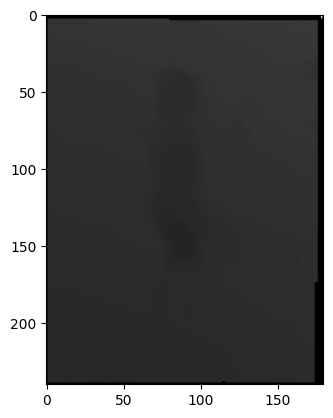

In [35]:
_ = plt.imshow(np.squeeze(depth), cmap='gray')
plt.show()

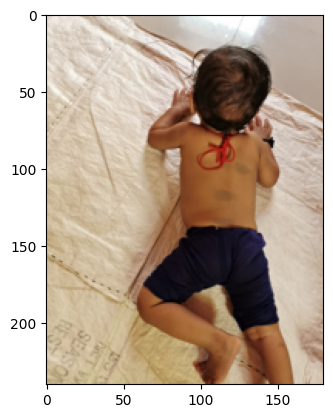

In [31]:
_ = plt.imshow(np.squeeze(rgb), cmap='gray')
plt.show()

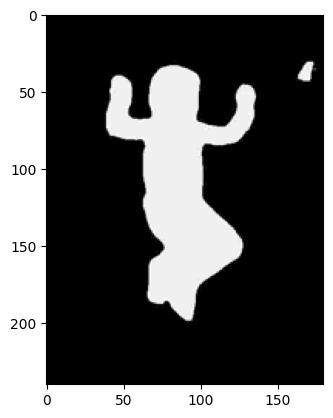

In [36]:
_ = plt.imshow(np.squeeze(segment), cmap='gray')
plt.show()

In [37]:
print(target)

{'scan_id': '00cce36c-1727-11ee-9aa3-a7d91250a55f', 'scan_step': 200, 'scan_version': 'v1.2.0', 'height': 65.3, 'weight': 5.6, 'muac': 11.8, 'device_model': 'HUAWEI VOG-L29', 'person_id': '00211c4e-1727-11ee-9a1b-37b62eea6d04', 'age': 260, 'sex': 'female', 'depth_artifact_id': '00cd61b6-1727-11ee-9aa4-f3888525e065', 'rgb_artifact_id': '00cff520-1727-11ee-9aad-fb2190534cba', 'depth_file_path': '1688116651809/5f9d368a-5b7f-4a63-8ed1-4773c2a4e2e8', 'rgb_file_path': '1688116653761/1af28819-1e16-43c1-ba72-4a9ed42a3e17', 'seg_file_path': '1688466001970/e9323163-105e-4970-a85f-08f76267f30b', 'order_number': 1, 'pose_data': {'Pose Scores': '0.8201421', 'Pose Results': "{'bbox_coordinates': [(262.08386, 257.50458), (828.15753, 1225.7235)], 'bbox_confidence_score': [0.9920779], 'key_points_coordinate': [{'nose': {'x': 354.84473, 'y': 598.70056}}, {'left_eye': {'x': 342.2378, 'y': 560.8795}}, {'right_eye': {'x': 335.9342, 'y': 623.9146}}, {'left_ear': {'x': 361.14832, 'y': 497.84442}}, {'right_ea

## Analysis

In [39]:
print("Total no. of artifacts:", len(df))
unique_scan_ids = df.drop_duplicates(subset='scan_id', keep='first')
print("Total no. of unique scan ids:", len(unique_scan_ids))
unique_person_ids = df.drop_duplicates(subset='person_id', keep='first')
print("Total no. of unique person ids:", len(unique_person_ids))

Total no. of artifacts: 150685
Total no. of unique scan ids: 11443
Total no. of unique person ids: 4576


HUAWEI VOG-L29    150685
Name: device_model, dtype: int64


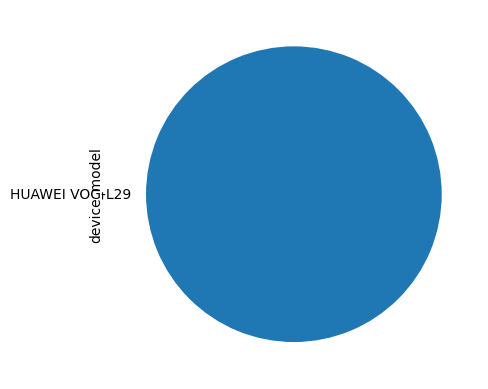

In [40]:
print(df['device_model'].value_counts())
_ = df['device_model'].value_counts().plot(kind='pie')

v1.2.0    58175
v0.8      56856
v1.2.1    35211
v0.9        443
Name: scan_version, dtype: int64


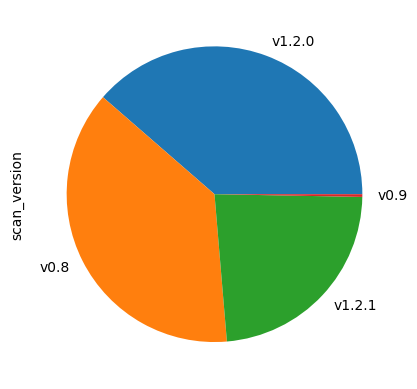

In [41]:
print(df['scan_version'].value_counts())
_ = df['scan_version'].value_counts().plot(kind='pie')

0     473
1    1025
2    1001
3     995
4    1071
5      11
Name: Years, dtype: int64


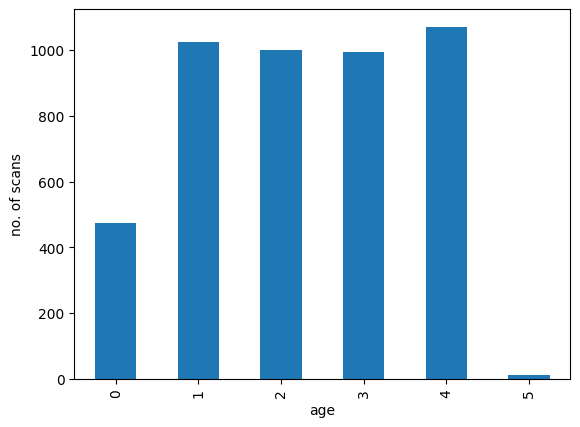

In [42]:
draw_age_distribution(unique_person_ids)

0     833
1    2196
2    2712
3    2700
4    2971
5      31
Name: Years, dtype: int64


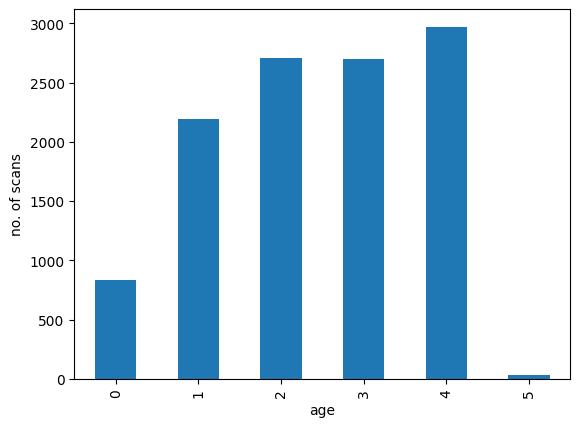

In [43]:
draw_age_distribution(unique_scan_ids)

101    91288
102    31371
100    15302
202     8573
200     4151
Name: scan_step, dtype: int64


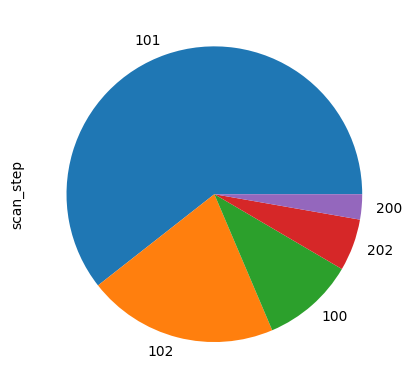

In [45]:
## keys for different scan type and their distribution in dataset
"- 100 - standing front scan",
"- 101 - standing 360 scan",
"- 102 - standing back scan",
"- 200 - lying front scan",
"- 201 - lying side scan",
"- 202 - lying back scan"
print(df['scan_step'].value_counts())
_ = df['scan_step'].value_counts().plot(kind='pie')

In [47]:
scan_type_colname = 'scan_step' # for other datasets this can be "key"
calculate_code_age_distribution(df, scan_type_colname)

2023-07-13 15:16:56,040 - INFO - scan_step - /mnt/batch/tasks/shared/LS_root/mounts/clusters/rbanka2/code/Users/rbanka/cgm-ml/cgmml/data_utils/dataset_EDA/data_utilities.py: line 52


,0,1,2,3,4
codes,,,,,
100,118,1717,3778,4313,5315
102,284,4002,8587,8720,9679
101,757,11593,24898,25513,28241
202,3749,4427,247,124,26
200,1859,2139,112,41,0


## Distribution of height, weight and age against each other

In [48]:
unique_scan_ids.head()

,scan_id,scan_step,scan_version,height,weight,muac,device_model,person_id,age,sex,depth_artifact_id,rgb_artifact_id,depth_file_path,rgb_file_path,seg_file_path,order_number,pose_data,no_of_person,device_pose,raw_header,angle,distance_to_child,depthmap_validity,pickle_file_path,Years
0,0015cae6-178c-11ee-b1cd-6fc5ed6a033f,100,v1.2.0,67.2,7.25,13.2,HUAWEI VOG-L29,ff9f05b4-178b-11ee-b16b-2b6bcb7c4a05,424,male,0016d0a8-178c-11ee-b1ce-9f4fb659476d,001995cc-178c-11ee-b1d7-5bebc04a202e,1688160019793/5d6613d9-a980-4a74-a415-21f958a4...,1688160021803/c772d898-4f5e-4493-b55c-83d291ef...,1688554674654/c1f4bb7e-cb06-4f89-83b0-1f01d3b0...,1,"{'Pose Scores': '0.1351201832294464', 'Pose Re...",2.0,"[-0.6657566243886109, -0.7442855129318473, -0....",240x180_0.001_7_-0.32789356_0.69144475_0.59563...,-41.574315,0.362,0.891329,scans/ff9f05b4-178b-11ee-b16b-2b6bcb7c4a05/100...,1
1,0019bda8-163e-11ee-9f3f-1ff29029e51a,100,v0.8,101.8,14.85,14.3,HUAWEI VOG-L29,fde725ca-163d-11ee-9d7c-cfee004ba43d,1407,female,001a62a8-163e-11ee-9f41-6b3f2e931c4e,001beb46-163e-11ee-9f4b-9f1490c8ef63,1688016582307/573d7b71-d500-4405-b280-1669820b...,1688016584333/272385aa-966a-41d2-bbb3-0c59fc21...,1688502968618/472e1059-4bf3-4b6c-bdd9-571d7f42...,2,"{'Pose Scores': '0.9608679413795471', 'Pose Re...",1.0,"[-0.20186411074441837, -0.9794118894204097, -0...",240x180_0.001_7_-0.46710086_0.5808739_0.519281...,-12.283541,0.701,0.835544,scans/fde725ca-163d-11ee-9d7c-cfee004ba43d/100...,3
7,0023158e-1818-11ee-bb01-c3b956fbd10b,102,v1.2.1,101.5,13.90,14.1,HUAWEI VOG-L29,ffaabbc0-1817-11ee-ba99-1b48bcd93175,1740,female,00246d80-1818-11ee-bb05-bb8d44325112,0026780a-1818-11ee-bb0e-f3934a21c7a9,1688220136979/ef5128a3-a584-45b6-a5c0-891369fa...,1688220138626/859ab704-f47d-48a5-bfef-ad40ebd9...,1688504375746/8ed2b3a3-9aa7-4a0c-95b3-b2a93cde...,4,"{'Pose Scores': '0.8424365520477295', 'Pose Re...",1.0,"[-0.5715028998635308, -0.8092605768604179, -0....",240x180_0.001_7_-0.3574718_0.6629384_0.6108135...,-39.440316,0.574,0.871739,scans/ffaabbc0-1817-11ee-ba99-1b48bcd93175/102...,4
16,00258374-177c-11ee-b3aa-077414d42183,102,v1.2.0,87.7,10.40,13.8,HUAWEI VOG-L29,ff985d5a-177b-11ee-b338-8f946759bfd3,1055,female,00263332-177c-11ee-b3ac-139e727936ea,00283056-177c-11ee-b3b5-93d5c5059d1a,1688153129614/c1bf645b-921c-4703-bf11-6c2958b5...,1688153131144/79cdbe34-930d-4d55-91a6-ab1d807d...,1688567583080/0ea3b086-a166-4ffa-9cb1-a4e1baf5...,2,"{'Pose Scores': '0.799994', 'Pose Results': ""{...",1.0,"[-0.6320017291171132, -0.7711729326670225, 0.0...",240x180_0.001_7_-0.32451552_0.62281615_0.64223...,-36.917027,0.682,0.871391,scans/ff985d5a-177b-11ee-b338-8f946759bfd3/102...,2
25,00286db4-17ef-11ee-b251-d7bd14a2f1cf,102,v1.2.1,100.0,13.95,15.4,HUAWEI VOG-L29,fe445a44-17ee-11ee-b0c2-a3084a66cd93,1395,male,00294432-17ef-11ee-b253-c3b7fab02d8b,002b16cc-17ef-11ee-b25b-1399e0e976ca,1688202550477/18df201d-5f70-4ded-a570-fb9ba7dd...,1688202552317/bdaa3859-0466-4423-9581-cd0807b6...,1688503906744/769928a6-f510-4800-8649-078dd5af...,7,"{'Pose Scores': '0.88713384', 'Pose Results': ...",1.0,"[-0.6320017291171132, -0.7711729326670225, 0.0...",240x180_0.001_7_-0.3401329_0.59390426_0.640069...,-31.518399,0.634,0.854276,scans/fe445a44-17ee-11ee-b0c2-a3084a66cd93/102...,3


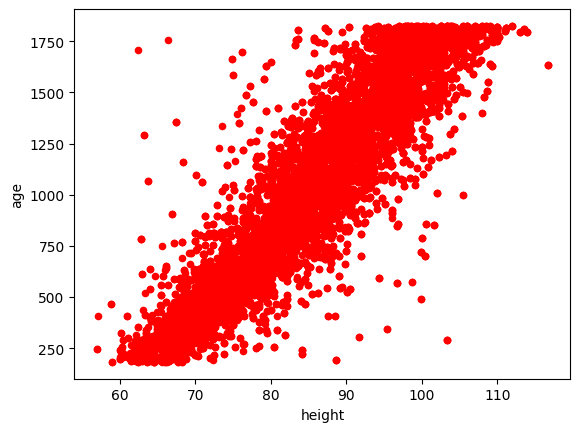

In [50]:
#distribution of height against age
height_vs_age = unique_scan_ids.plot.scatter(x='height', y='age', c='red')

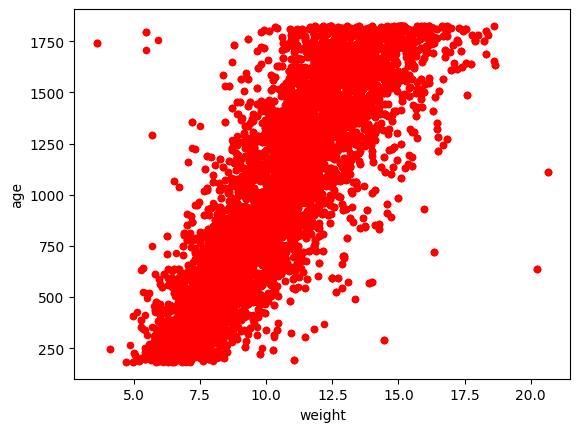

In [51]:
#distribution of weight against age
weight_vs_age = unique_scan_ids.plot.scatter(x='weight', y='age', c='red')

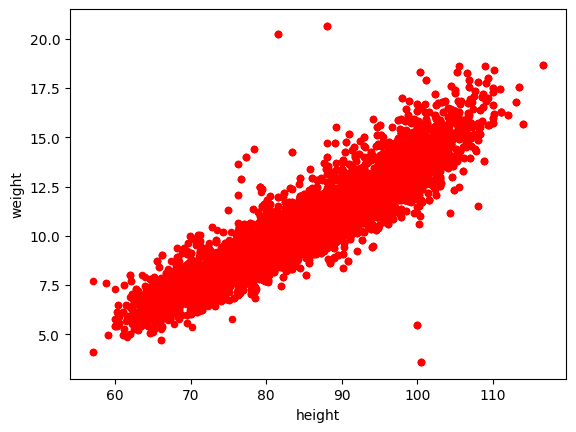

In [52]:
weight_vs_height = unique_scan_ids.plot.scatter(x='height', y='weight', c='red')

## Analyze outliers: 1) age, 2) weight, 3) height, 4) pixel values

In [53]:
df.describe()

,scan_step,height,weight,muac,age,order_number,no_of_person,angle,distance_to_child,depthmap_validity,Years
count,150685.000000,150685.000000,150685.000000,150685.000000,150685.000000,150685.000000,150685.000000,150669.000000,1.506850e+05,150685.000000,150685.000000
mean,109.580091,87.670092,11.095012,13.843073,1139.724418,10.244006,1.082722,-37.884001,1.101773e+15,0.875230,2.591691
std,27.875816,10.253883,2.393344,1.005657,437.332443,7.513434,0.375618,16.769335,1.008014e+17,0.057126,1.191607
min,100.000000,57.000000,3.600000,9.600000,183.000000,1.000000,1.000000,-89.990946,2.800000e-02,0.000000,0.000000
25%,101.000000,80.200000,9.350000,13.200000,804.000000,4.000000,1.000000,-43.311899,4.820000e-01,0.846431,2.000000
50%,101.000000,88.300000,11.100000,13.800000,1167.000000,8.000000,1.000000,-36.015206,5.920000e-01,0.876995,3.000000
75%,102.000000,95.700000,12.700000,14.500000,1517.000000,16.000000,1.000000,-27.798797,7.020000e-01,0.907535,4.000000
max,202.000000,116.700000,20.650000,18.200000,1825.000000,52.000000,13.000000,9.893391,9.223372e+18,1.000000,5.000000


In [54]:
unique_scan_ids.describe()

,scan_step,height,weight,muac,age,order_number,no_of_person,angle,distance_to_child,depthmap_validity,Years
count,11443.000000,11443.000000,11443.000000,11443.000000,11443.000000,11443.000000,11443.000000,11442.000000,1.144300e+04,11443.000000,11443.000000
mean,116.332343,86.273818,10.809511,13.789505,1080.310583,7.326226,1.091410,-40.191706,1.612055e+15,0.883135,2.425850
std,35.961438,10.878023,2.489815,1.014788,461.559089,6.119728,0.385725,19.341646,1.219315e+17,0.058857,1.265209
min,100.000000,57.000000,3.600000,9.600000,183.000000,1.000000,1.000000,-89.753799,3.000000e-02,0.000000,0.000000
25%,101.000000,78.400000,8.950000,13.100000,707.000000,3.000000,1.000000,-44.814450,4.790000e-01,0.852103,1.000000
50%,101.000000,87.000000,10.800000,13.700000,1092.000000,6.000000,1.000000,-36.426794,5.850000e-01,0.881794,2.000000
75%,102.000000,95.000000,12.550000,14.400000,1477.000000,9.000000,1.000000,-28.072702,6.900000e-01,0.916020,4.000000
max,202.000000,116.700000,20.650000,18.200000,1825.000000,42.000000,8.000000,9.893391,9.223372e+18,1.000000,5.000000


### 1) Check age

In [55]:
find_outliers(df, 'age', '<365/2', data_id_name='person_id')

Running the following query: @df.age<365/2
No. of outliers: 0


[]

In [56]:
find_outliers(df, 'age', '<365/2', data_id_name='scan_id')

Running the following query: @df.age<365/2
No. of outliers: 0


[]

In [57]:
find_outliers(df, 'age', '>365*6', data_id_name='scan_id')

Running the following query: @df.age>365*6
No. of outliers: 0


[]

### 2) Check weight

In [59]:
find_outliers(df, 'weight', '<5.0', data_id_name='scan_id')

Running the following query: @df.weight<5.0
No. of outliers: 12


['110b6796-1810-11ee-b8b6-efa90b83c21b',
 '1163dda4-1810-11ee-b8f8-dbb3ba45bedf',
 '12170406-1810-11ee-b984-078c79266d8b',
 '19be322c-163c-11ee-b09c-4f282cd74d6d',
 '19c34156-177f-11ee-adf1-c709c8253187',
 '1b00b286-163c-11ee-b1a7-633cd923b7c9',
 '1b247d9e-177f-11ee-af03-13a75bb39ba6',
 '34bf5136-17be-11ee-a4e3-cb3b3fec44c6',
 '3609b6b2-17be-11ee-a5fe-07ba1a05a155',
 '8465ad46-1658-11ee-af0e-f7f60e24a5ec',
 'e7679bcc-1629-11ee-aa71-4b9afca66963',
 'e91c8c34-1629-11ee-abbd-e7ebe8227cb7']

In [60]:
find_outliers(df, 'weight', '>30.0', data_id_name='scan_id')

Running the following query: @df.weight>30.0
No. of outliers: 0


[]

### 3) Check height

In [61]:
find_outliers(df, 'height', '<40.0', data_id_name='scan_id')

Running the following query: @df.height<40.0
No. of outliers: 0


[]

In [62]:
find_outliers(df, 'height', '>150.0', data_id_name='scan_id')

Running the following query: @df.height>150.0
No. of outliers: 0


[]

In [63]:
# now close the mount context
mount_ctx.stop()